# Análisis de la calidad de datos abiertos de personal del portal de datos abiertos del CPLT

### ¿Qué tan uniformes son los campos de las distintas fuentes de datos abiertos de la contratación de personal?

In [2]:
import pandas as pd
# importamos las columnas de cada archivo
col_planta = pd.read_csv('G:/temp2/TA_PersonalPlanta.csv', nrows=1, encoding='cp1252', sep=';').keys().tolist()
col_contrata = pd.read_csv('G:/temp2/TA_PersonalContrata.csv', nrows=1, encoding='cp1252', sep=';').keys().tolist()
col_honorarios = pd.read_csv('G:/temp2/TA_PersonalContratohonorarios.csv', nrows=1, encoding='cp1252', sep=';').keys().tolist()
col_codigo = pd.read_csv('G:/temp2/TA_PersonalCodigotrabajo.csv', nrows=1, encoding='cp1252', sep=';').keys().tolist()

# unimos las columnas en una lista
cols = [col_planta, col_contrata, col_honorarios, col_codigo]

# loop para revisar cuales son todos los campos
col_t = []
for l in cols:
    for col in l:
        if col not in col_t:
            col_t.append(col)
            
# se almacena en un dataframe
dfcols = pd.DataFrame(col_t, columns =['Campos'])

# se crean los otros dataframes para luego hacer un merge
dfs = ['dfplanta', 'dfcontrata', 'dfhonorarios', 'dfcodigo']
datasets = ['Planta', 'Contrata', 'Honorarios', 'Codigo del trabajo']

a = zip(dfs, cols)

lista_dfs = {}
for df, file in a:
    lista_dfs[df] = pd.DataFrame(file, columns=['Campos'])
    lista_dfs[df]['Existe'] = 'Si'
    
for i, dfs in enumerate(lista_dfs):
    dfcols = dfcols.merge(lista_dfs[dfs], how='left').rename(columns={'Existe':datasets[i]})
dfcols = dfcols.fillna('No')

dfcols

,Campos,Planta,Contrata,Honorarios,Codigo del trabajo
0,camino,Si,Si,Si,Si
1,organismo_nombre,Si,Si,Si,Si
2,organismo_codigo,Si,Si,Si,Si
3,fecha_publicacion,Si,Si,Si,Si
4,anyo,Si,Si,Si,Si
5,Mes,Si,Si,Si,Si
6,Tipo Estamento,Si,Si,No,No
7,nombre,Si,Si,Si,Si
8,grado_eus,Si,Si,Si,Si
9,tipo_calificacionp,Si,Si,Si,Si


### ¿Cuál es el campo que indica la fecha o periódo de publicación?

In [3]:
#Importamos las credenciales que usaremos en todo el notebook para conectarnos al ambiente de vertica
import os
import vertica_python

user = os.getenv('vertuser')
passwd = os.getenv('vertpass')
host = os.getenv('verthost')
db = os.getenv('vertdb')
port = os.getenv('vertport')

# información de conexión a vertica
conn_info = {'host': host,
             'port': port,
             'user': user,
             'password': passwd,
             'database': db,
             'unicode_error': 'strict',
             'ssl': False,
             'use_prepared_statements': False}

In [4]:
# conexión simple con cierre manual
cnxn = vertica_python.connect(**conn_info)

# Hacemos la query  e importamos el resultado en un df
query1 = '''
SELECT round(SUM(año)/count(año), 4) * 100 as '% en que no coincide año', 
round(SUM(Mes)/count(Mes), 4) * 100 as '% en que no coincide mes',
round(SUM(Ambos)/count(Ambos), 4) * 100 as '% en que no coinciden ambos'
FROM (
SELECT 
CASE WHEN f.anyo = YEAR(date(fechapublicacion)) then 0 else 1 end as año,
CASE WHEN to_number(MesN) = month(date(fechapublicacion)) then 0 else 1 end as Mes,
CASE WHEN to_number(MesN) = month(date(fechapublicacion)) and f.anyo = YEAR(date(fechapublicacion)) then 0 else 1 end as Ambos
FROM funcionarios."full" f 
) as t
'''

df1 = pd.read_sql(query1, cnxn)

cnxn.close()
df1

,% en que no coincide año,% en que no coincide mes,% en que no coinciden ambos
0,89.15,92.88,99.99


### ¿Desde cuando se publica?

In [5]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# hacemos la query  e importamos el resultado en un df
query2 = '''
SELECT f.anyo as Año , f.Mes  as Mes , count(*) as 'Cantidad de registros'
FROM funcionarios."full" f 
GROUP BY f.anyo , f.Mes, mesN
order by f.anyo, mesN asc
'''

df2 = pd.read_sql(query2, con=cnxn)
# añadimos año-mes
df2['mesAño'] = df2['Año'].astype(str) + '-' + df2['Mes']

cnxn.close()

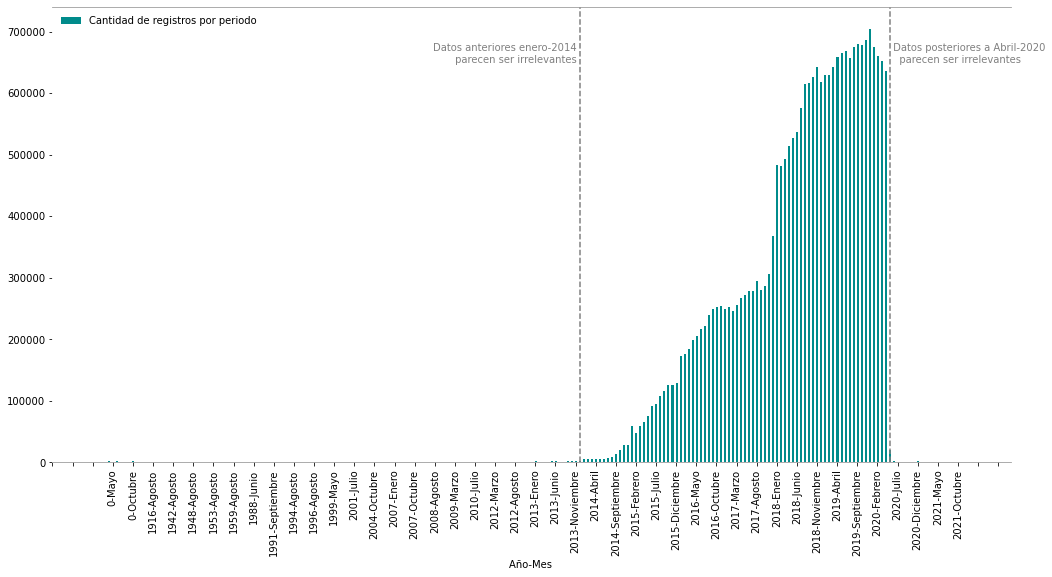

In [6]:
import matplotlib.pyplot as plt
import numpy as np

y = df2['Cantidad de registros']
x = df2['mesAño']

fig, ax = plt.subplots(figsize=(14,7))
plt.xticks(rotation=90)
plt.tight_layout() 
plt.bar(x, y, width=0.5, color='darkcyan')
stepsize = 5
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, stepsize)) 
ax.set_xlabel('Año-Mes ')

# color de los ejes 
ax.spines['bottom'].set_color('#999')
ax.spines['top'].set_color('#999') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.legend(['Cantidad de registros por periodo'], loc = 'upper left', shadow = False, edgecolor = 'white')

plt.text(df2['mesAño'][df2[df2['mesAño'] == '2013-Diciembre'].index.values[0]], 650000,\
         'Datos anteriores enero-2014 \n parecen ser irrelevantes ', color = 'grey',\
        horizontalalignment='right')

plt.text(df2['mesAño'][df2[df2['mesAño'] == '2020-Mayo'].index.values[0]], 650000,\
         ' Datos posteriores a Abril-2020\n   parecen ser irrelevantes', color = 'grey',\
        horizontalalignment='left')

ax.axvline(x='2013-Diciembre', color = 'grey', ls = '--')
ax.axvline(x='2020-Mayo', color = 'grey', ls = '--')
plt.show()

### ¿Quienes publican periodos inconsistentes?

In [87]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# hacemos la query  e importamos el resultado en un df
query3 = '''
SELECT f.OrganismoCodigo, f.OrganismoNombre, count(distinct concat(f.anyo, f.Mes)) cant_periodos 
FROM funcionarios."full" f 
WHERE (f.anyo < 2010 or f.anyo > 2021)
or (f.anyo > 2020 and f.mesN in ('05', '06', '07', '08', '09', '10', '11', '12'))
GROUP  By f.OrganismoCodigo, f.OrganismoNombre
'''

df3 = pd.read_sql(query3, con=cnxn)

cnxn.close()
print(len(df3))
rank10 = df3.sort_values(by='cant_periodos', ascending=False).head(10).sort_values(by='cant_periodos')

212


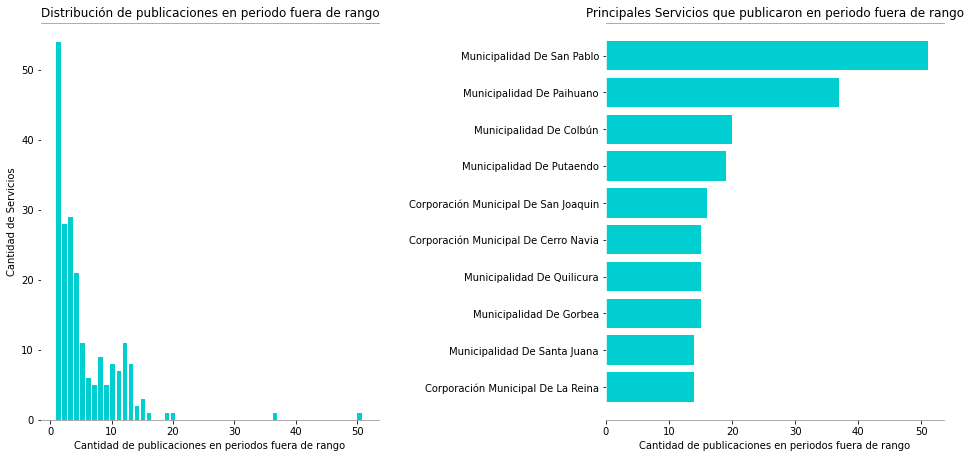

In [89]:
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, figsize=(14,7))
y1 = rank10['OrganismoNombre']
x1 = rank10['cant_periodos']

x2 = df3['cant_periodos']

# color de los ejes 
ax0.spines['bottom'].set_color('#999')
ax0.spines['top'].set_color('#999') 
ax0.spines['right'].set_color('white')
ax0.spines['left'].set_color('white')

# color de los ejes 
ax1.spines['bottom'].set_color('#999')
ax1.spines['top'].set_color('#999') 
ax1.spines['right'].set_color('white')
ax1.spines['left'].set_color('white')

ax0.hist(x2, bins = 51, color = 'darkturquoise', width=0.7)
ax0.set_title('Distribución de publicaciones en periodo fuera de rango')
ax0.set_xlabel('Cantidad de publicaciones en periodos fuera de rango')
ax0.set_ylabel('Cantidad de Servicios')

ax1.barh(y1, x1, color= 'darkturquoise')
ax1.set_xlabel('Cantidad de publicaciones en periodos fuera de rango')
ax1.set_title('Principales Servicios que publicaron en periodo fuera de rango')

plt.rcParams["font.family"] = "sans-serif"
fig.tight_layout(pad=3)
plt.show()

### ¿Cuándo se hicieron estos registros equivocados?

In [26]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# hacemos la query  e importamos el resultado en un df
query4 = '''
SELECT date(FechaPublicacion) fecha , count(distinct OrganismoCodigo ) cantidadservicios, count(f.FechaPublicacion) cantidadregistros
FROM funcionarios."full" f 
WHERE (f.anyo < 2010 or f.anyo > 2021)
or (f.anyo > 2020 and f.mesN in ('05', '06', '07', '08', '09', '10', '11', '12'))
GROUP  By date(FechaPublicacion)
'''
df4 = pd.read_sql(query4, con=cnxn)
df4.fecha = pd.to_datetime(df4['fecha'])
df4 = df4.sort_values(by=['fecha'])
cnxn.close()

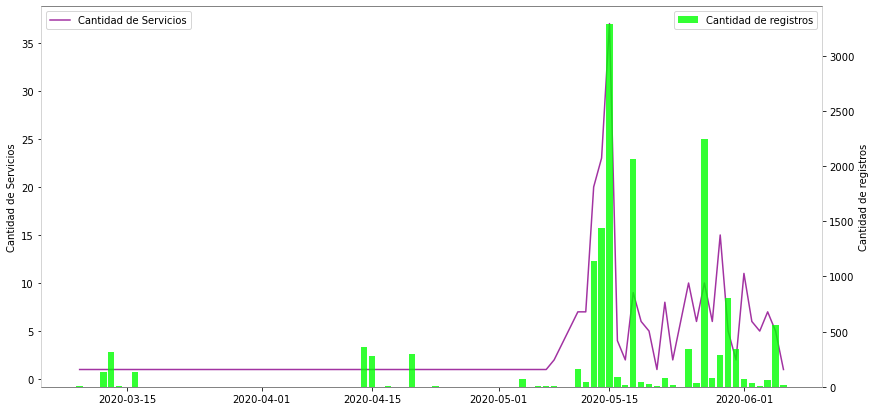

In [95]:
fig, ax = plt.subplots(figsize=(14,7))
ax1 = ax.twinx()
ax.plot(df4['fecha'], df4['cantidadservicios'], alpha=0.8, c='darkmagenta')
ax1.bar(df4['fecha'], df4['cantidadregistros'], alpha=0.8, color='lime')

ax.set(ylabel='Cantidad de Servicios')
ax1.set(ylabel='Cantidad de registros')
ax.legend(['Cantidad de Servicios'], loc='upper left')
ax1.legend(['Cantidad de registros'], loc='upper right')

# color de los ejes 
ax0.spines['bottom'].set_color('#999')
ax0.spines['top'].set_color('#999') 
ax0.spines['right'].set_color('white')
ax0.spines['left'].set_color('white')

ax1.spines['bottom'].set_color('#999')
ax1.spines['top'].set_color('#999') 
ax1.spines['right'].set_color('white')
ax1.spines['left'].set_color('white')

plt.show()